In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as gauss
%matplotlib inline

In [2]:
# Distribution parameters
pi = np.array([0.4, 0.6])
mu = np.array([[2.0, 50.0], 
               [4.5, 80.0]])
sigma = np.array([[[0.1, 0.2], [0.2, 25.0]], 
                  [[0.3, 2.0], [2.0, 30.0]]])
N = 272
K, D = mu.shape
assert pi.sum() == 1.0

In [11]:
# Sample data from the distributions
X = []
for k in range(K):
    X.append(np.random.multivariate_normal(mu[k], sigma[k], size=int(N*pi[k]+0.5)))
X = np.vstack((X[0], X[1]))

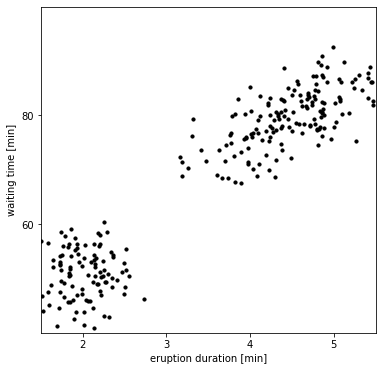

In [12]:
# Show the data
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], c='black', s=10)
plt.xlim([1.5, 5.5])
plt.xticks([2, 3, 4, 5])
plt.xlabel('eruption duration [min]')
plt.ylim([40, 100])
plt.yticks([60, 80])
plt.ylabel('waiting time [min]')
plt.show()

In [13]:
# Initialize parameters
pi_pred = np.array([0.5, 0.5])
mu_pred = np.array([[2.0, 90.0], 
                    [5.0, 50.0]])
sigma_pred = np.array([[[0.2, 0.0], [0.0, 20.0]], 
                       [[0.2, 0.0], [0.0, 20.0]]])
eps = 1e-3

In [14]:
# Plotting
x1 = np.linspace(1.5, 5.5, 100)
x2 = np.linspace(40, 100, 100)
xx1, xx2 = np.meshgrid(x1, x2)
xx12 = np.hstack((xx1.reshape(-1, 1), xx2.reshape(-1, 1)))

def plot_gaussians(mu_pred, sigma_pred, E_c, i):
    plt.figure(figsize=(6, 6))
    plt.contourf(x1,x2,gauss.pdf(xx12, mean=mu_pred[1], cov=sigma_pred[1]).reshape(100, 100), alpha=0.5, levels=100, cmap='Oranges')
    plt.contourf(x1,x2,gauss.pdf(xx12, mean=mu_pred[0], cov=sigma_pred[0]).reshape(100, 100), alpha=0.5, levels=100, cmap='Blues')
    plt.scatter(X[:, 0], X[:, 1], c='black', s=10)
    plt.xlim([1.5, 5.5])
    plt.xticks([2, 3, 4, 5])
    plt.xlabel('eruption duration [min]')
    plt.ylim([40, 100])
    plt.yticks([60, 80])
    plt.ylabel('waiting time [min]')
    plt.title('Expected complete-data log likelihood: %.3f' % E_c)
    plt.savefig('images/EM_%03d.png' % i)

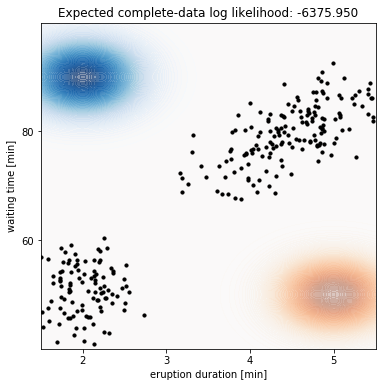

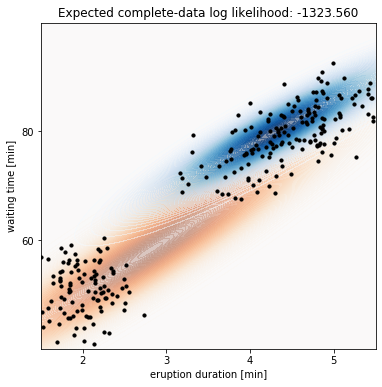

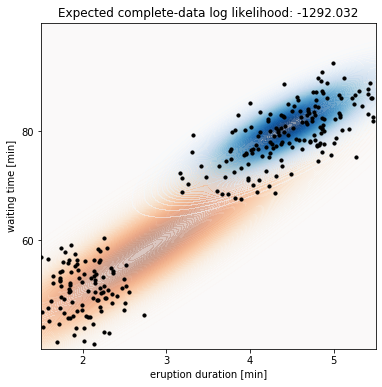

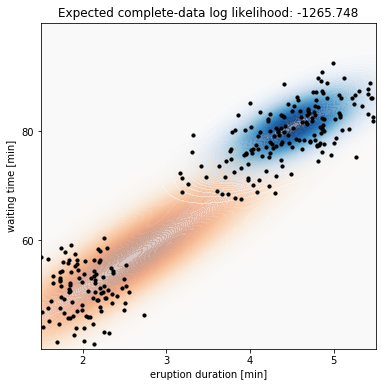

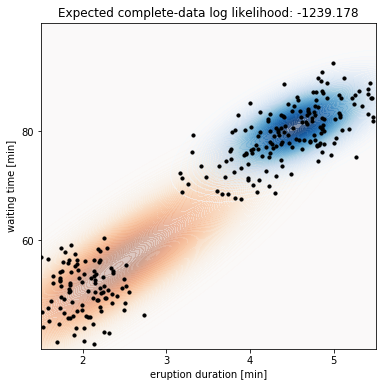

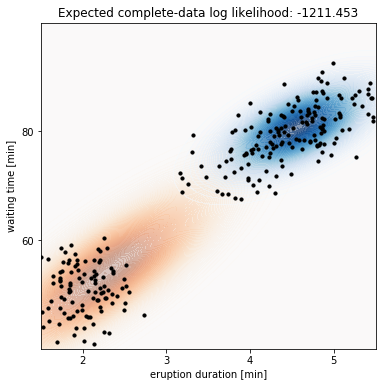

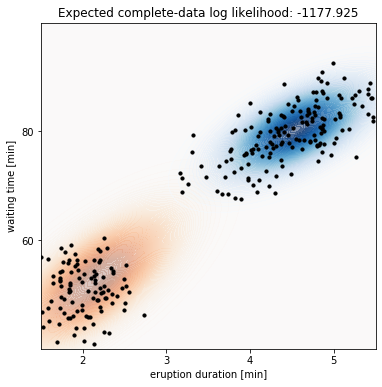

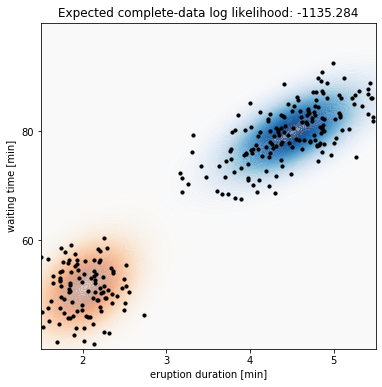

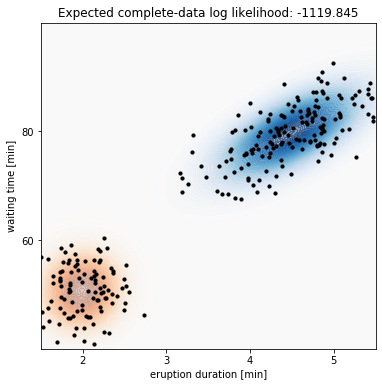

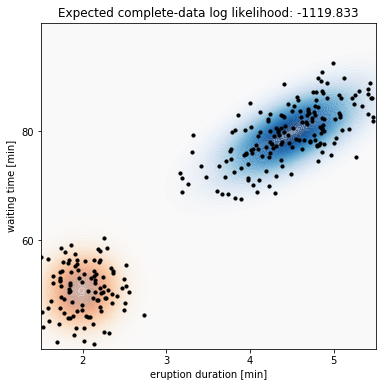

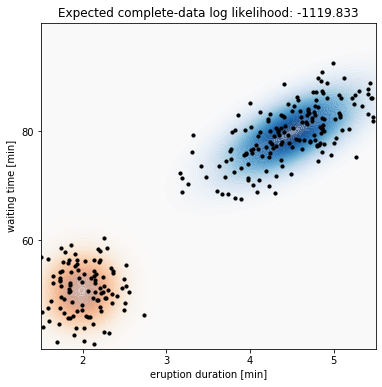

In [15]:
E_c = 0
for i in range(20):
    # E-step
    gamma = np.zeros(shape=(N, K))
    for k in range(K):
        gamma[:, k] = gauss.pdf(X, mean=mu_pred[k], cov=sigma_pred[k]) * pi_pred[k]
    gamma = gamma/np.sum(gamma, axis=1, keepdims=True)
    
    prev_E_c = E_c
    E_c = 0
    for k in range(K):
        E_c += np.sum(gamma[:, k] * (np.log(gauss.pdf(X, mean=mu_pred[k], cov=sigma_pred[k])) + np.log(pi_pred[k])))
    
    # Save the plot
    plot_gaussians(mu_pred, sigma_pred, E_c, i)
    
    # Check for convergence
    if np.abs(E_c - prev_E_c) < eps:
        break
    
    # M-step
    pi_pred = np.sum(gamma, axis=0)/np.sum(gamma)
    for k in range(K):
        mu_pred[k, :] = np.sum(gamma[:, k].reshape(-1,1)*X, axis=0)/np.sum(gamma[:, k], keepdims=True)
        sigma_pred[k, :, :] = np.sum(
            gamma[:, k].reshape(-1, 1, 1) *\
            ((X-mu_pred[k, :]).reshape(N, D, 1)@(X-mu_pred[k, :]).reshape(N, 1, D)), axis=0) /\
            np.sum(gamma[:, k])

In [16]:
print(pi_pred)
print(mu_pred)
print(sigma_pred)

[0.59927672 0.40072328]
[[ 4.48508242 79.66954061]
 [ 1.98961995 50.72244018]]
[[[ 0.29627061  2.00628709]
  [ 2.00628709 29.99803697]]

 [[ 0.09129388  0.0552618 ]
  [ 0.0552618  21.19786632]]]
